# Covid-19

Pete Arnold

19.4.2020

## Data Source

https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

http://www2.nphs.wales.nhs.uk:8080/CommunitySurveillanceDocs.nsf/Public/77FDB9A33544AEE88025855100300CAB/$file/Rapid%20COVID-19%20surveillance%20data.xlsx


In [1]:
#library(here)
library(tidyverse)
library(lubridate)
library(readxl)

source('covid-19_functions.R')

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date




## Update data from source(s) and reload

In [3]:
load_data('covid-19.csv') %>% archive_data('covid-19')
# From Europe.
update_data('http://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx', 'covid-19.csv')
# And from Public Health Wales.
update_data_wales('http://www2.nphs.wales.nhs.uk:8080/CommunitySurveillanceDocs.nsf/Public/77FDB9A33544AEE88025855100300CAB/$file/Rapid%20COVID-19%20surveillance%20data.xlsx?OpenElement', 'covid-19-wales.csv')

Parsed with column specification:
cols(
  dateRep = col_datetime(format = ""),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2018 = col_double(),
  continentExp = col_character()
)

New names:
* `` -> ...2
* `` -> ...3



## Manipulate the Wales data to match the ECDC data and merge the two

In [4]:
cases_wales <- load_data_xlsx('covid-19-wales.xlsx', sheet='Tests by specimen date') %>%
    rename_all(list(~make.names(.)))

cases_wales_modified <- cases_wales %>%
    transmute(dateRep=Specimen.date, day=day(dateRep), month=month(dateRep), 
              year=year(dateRep), cases=Cases..new., deaths=NA, 
              countriesAndTerritories=Local.Authority, geold=NA,
              countryterritoryCode=NA, popData2018=NA, continentExp=NA,
              cum_cases=Cumulative.cases)

deaths_wales <- load_data_xlsx('covid-19-wales.xlsx', sheet='Deaths by date') %>%
    rename_all(list(~make.names(.)))

deaths_wales_modified <- deaths_wales %>%
    transmute(dateRep=Date.of.death, deaths=Daily.deaths, cum_deaths=Cumulative.deaths)

cases_all_wales <- cases_wales %>%
    select(-Local.Authority) %>% group_by(Specimen.date) %>%
    mutate(Cases..new.=sum(Cases..new.), Cumulative.cases=sum(Cumulative.cases)) %>%
    filter(row_number()==1) %>% ungroup()

cases_all_wales_modified <- cases_all_wales %>%
    transmute(dateRep=Specimen.date, day=day(dateRep), month=month(dateRep), 
              year=year(dateRep), cases=Cases..new., 
              countriesAndTerritories='Wales', geoId=NA,
              countryterritoryCode=NA, popData2018=3187203, continentExp='Europe',
              cum_cases=Cumulative.cases) %>%
    merge(deaths_wales_modified, by='dateRep', all=TRUE) %>% distinct() %>%
    transmute(dateRep, day, month, year, cases, deaths, countriesAndTerritories,
           geoId, countryterritoryCode, popData2018, continentExp,
           cum_cases, cum_deaths) %>%
    mutate(deaths=ifelse(is.na(deaths), 0, deaths))

In [5]:
cases_deaths <-
    load_data('covid-19.csv') %>%
    clean_data() %>%
    remove_known_problems()

Parsed with column specification:
cols(
  dateRep = col_datetime(format = ""),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  cases = col_double(),
  deaths = col_double(),
  countriesAndTerritories = col_character(),
  geoId = col_character(),
  countryterritoryCode = col_character(),
  popData2018 = col_double(),
  continentExp = col_character()
)

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone '%d/%m/%Y'"


In [6]:
cases_deaths <- cumulative_cases(cases_deaths) 
cases_deaths <- cumulative_deaths(cases_deaths)

# Now incorporate the Welsh national data.
cases_deaths <- cases_deaths %>%
    rbind(cases_all_wales_modified)

cases_deaths <- cases_deaths %>%
    smooth_cases() %>%
    smooth_deaths()

In [7]:
no_countries <- (cases_deaths %>%
    select(countriesAndTerritories) %>% distinct %>% count())[[1]]
cat('Country count = ', no_countries, '\n', sep='')

countries_cases_deaths <- cases_deaths %>%
    get_max_cases_deaths()

countries_smoothed_cases_deaths <- cases_deaths %>%
    get_max_smoothed_cases_deaths()

countries_cum_cases <- cases_deaths %>%
    get_max_cumulative_cases()

countries_first_case <- cases_deaths %>%
    left_join(countries_cases_deaths, by='countriesAndTerritories') %>% 
    left_join(countries_smoothed_cases_deaths, by='countriesAndTerritories') %>%
    get_first_smoothed_case_at_pc(15)

#countries_first_case <- cases_deaths %>%
#    get_first_case()

countries <- countries_cases_deaths %>%
    full_join(countries_first_case, by='countriesAndTerritories') %>%
    full_join(countries_cum_cases, by='countriesAndTerritories') %>%
    full_join(countries_smoothed_cases_deaths, by='countriesAndTerritories')

cat('Merged country data size = ', count(countries)[[1]], '\n', sep='')

Country count = 211
Merged country data size = 211


Brazil ,  18377 ,  33274 ,  12 
China ,  18287 ,  4156 ,  4 
France ,  18335 ,  7578 ,  8 
Germany ,  18337 ,  6294 ,  6 
Italy ,  18328 ,  6557 ,  3 
Japan ,  18348 ,  1401 ,  10 
Russia ,  18364 ,  11656 ,  9 
South_Korea ,  18313 ,  909 ,  2 
Spain ,  18334 ,  9181 ,  7 
United_Kingdom ,  18344 ,  8719 ,  1 
United_States_of_America ,  18342 ,  48529 ,  5 
Vietnam ,  18328 ,  26 ,  11 
Brazil ,  18377 ,  1188 ,  12 


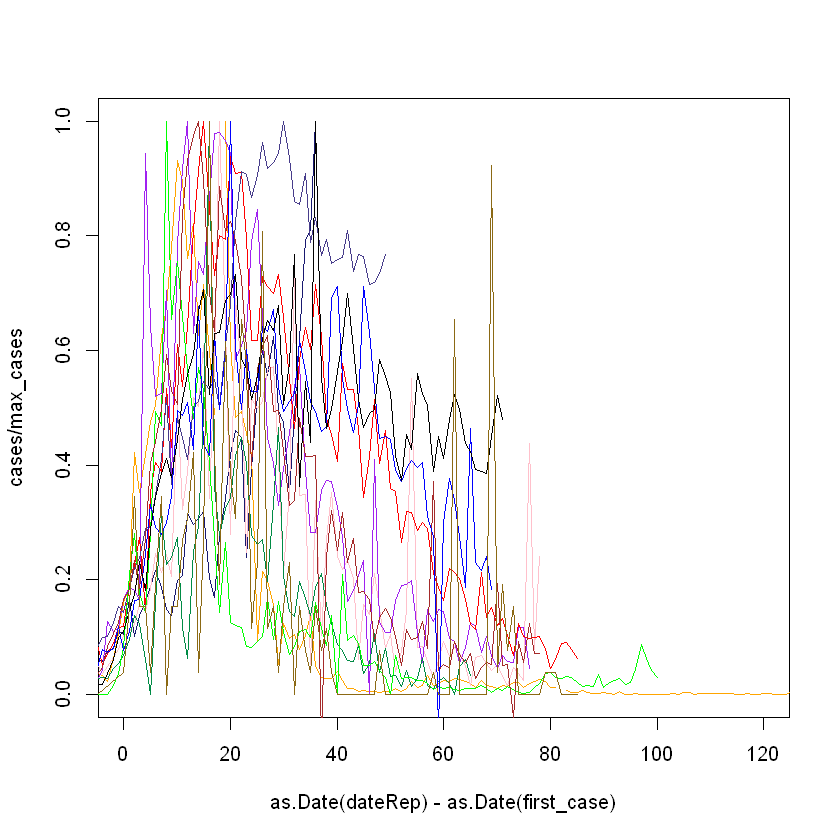

China ,  18287 ,  150 ,  4 
France ,  18335 ,  2004 ,  8 
Germany ,  18337 ,  315 ,  6 
Italy ,  18328 ,  971 ,  3 
Japan ,  18348 ,  101 ,  10 
Russia ,  18364 ,  232 ,  9 
South_Korea ,  18313 ,  9 ,  2 
Spain ,  18334 ,  950 ,  7 
United_Kingdom ,  18344 ,  1172 ,  1 
United_States_of_America ,  18342 ,  4928 ,  5 
Vietnam ,  18328 ,  0 ,  11 


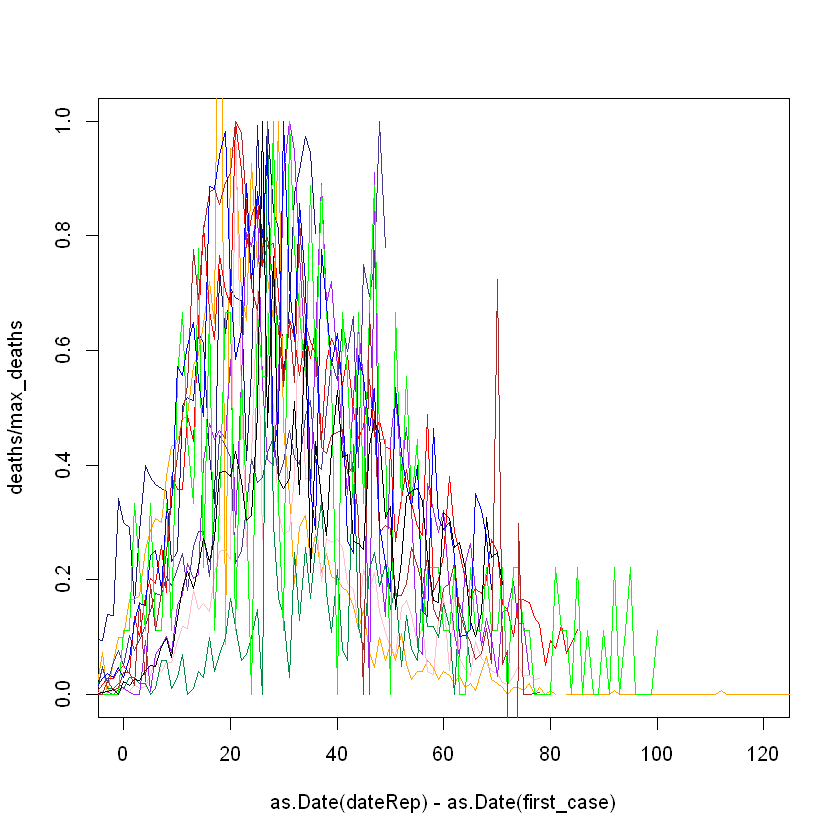

In [8]:
selected_countries <- c('United_Kingdom', 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany', 'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c('blue', 'green', 'red', 'orange', 'black', 'purple', 'brown', 'pink', 'slateblue4', 'springgreen4', 'goldenrod4', 'midnightblue')
period <- 120
# Cases.
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), cases/max_cases, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), cases/max_cases, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
# Deaths.
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), deaths/max_deaths, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), deaths/max_deaths, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}

China ,  18287 ,  3482.8 ,  4 
France ,  18335 ,  4832.8 ,  8 
Germany ,  18337 ,  5960.2 ,  6 
Italy ,  18328 ,  5709 ,  3 
Russia ,  18364 ,  11083 ,  9 
South_Korea ,  18313 ,  661.2 ,  2 
Spain ,  18334 ,  8524.6 ,  7 
United_Kingdom ,  18344 ,  5807.4 ,  1 
United_States_of_America ,  18342 ,  32785 ,  5 
Wales ,  18340 ,  370.8 ,  10 
China ,  18287 ,  3482.8 ,  4 


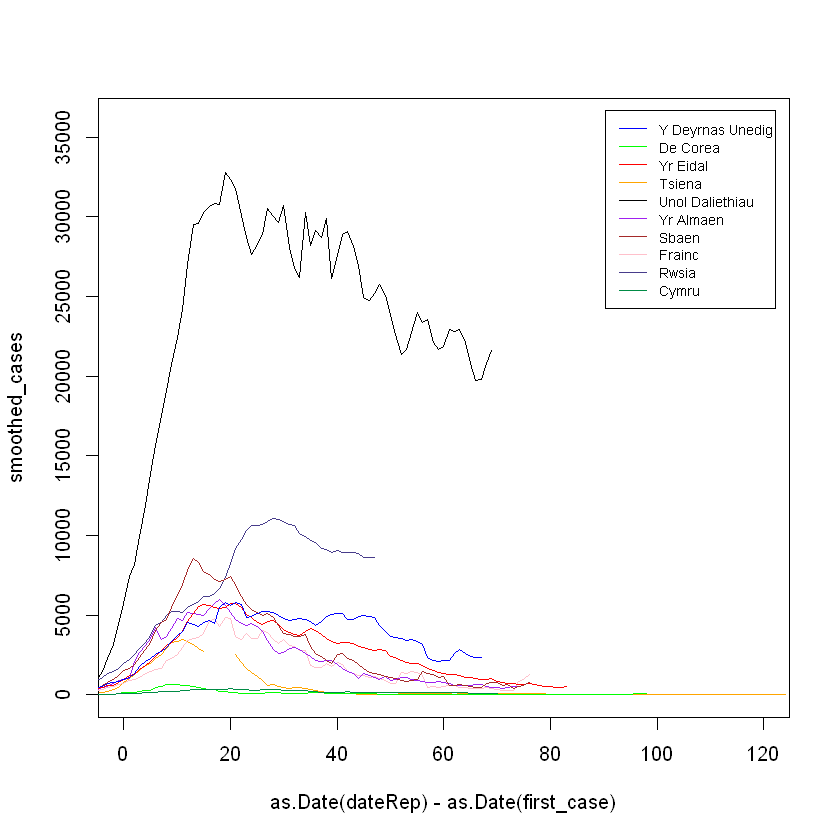

France ,  18335 ,  4832.8 ,  8 
Germany ,  18337 ,  5960.2 ,  6 
Italy ,  18328 ,  5709 ,  3 
Russia ,  18364 ,  11083 ,  9 
South_Korea ,  18313 ,  661.2 ,  2 
Spain ,  18334 ,  8524.6 ,  7 
United_Kingdom ,  18344 ,  5807.4 ,  1 
United_States_of_America ,  18342 ,  32785 ,  5 
Wales ,  18340 ,  370.8 ,  10 
China ,  18287 ,  125.4 ,  4 


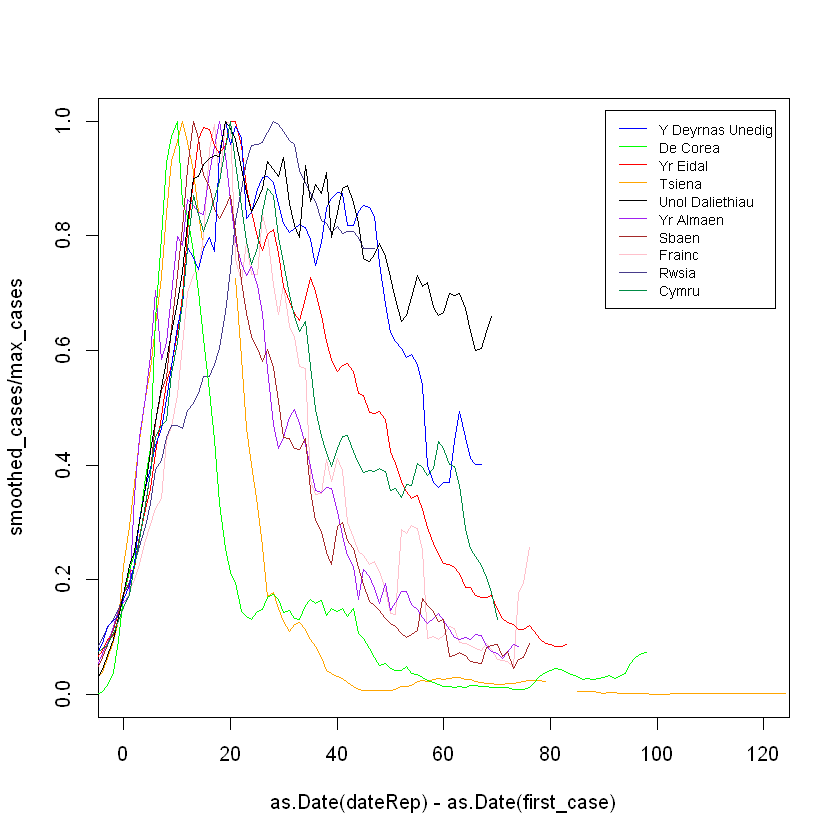

France ,  18335 ,  1165 ,  8 
Germany ,  18337 ,  265 ,  6 
Italy ,  18328 ,  853 ,  3 
Russia ,  18364 ,  184.4 ,  9 
South_Korea ,  18313 ,  7 ,  2 
Spain ,  18334 ,  881.4 ,  7 
United_Kingdom ,  18344 ,  1033.2 ,  1 
United_States_of_America ,  18342 ,  3052.2 ,  5 
Wales ,  18340 ,  35.8 ,  10 
China ,  18287 ,  125.4 ,  4 


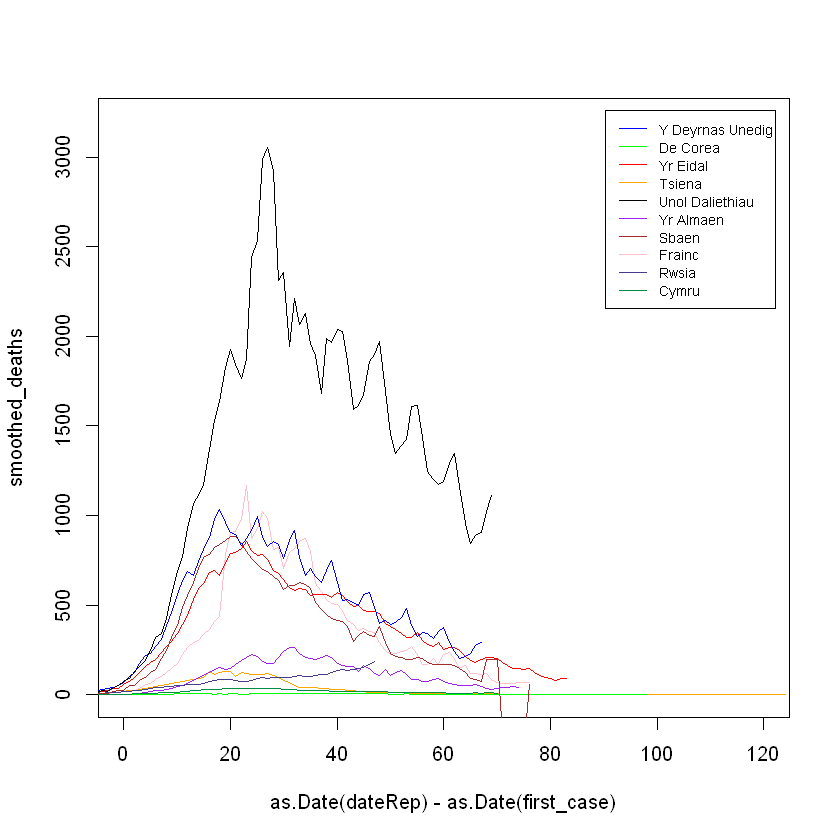

France ,  18335 ,  1165 ,  8 
Germany ,  18337 ,  265 ,  6 
Italy ,  18328 ,  853 ,  3 
Russia ,  18364 ,  184.4 ,  9 
South_Korea ,  18313 ,  7 ,  2 
Spain ,  18334 ,  881.4 ,  7 
United_Kingdom ,  18344 ,  1033.2 ,  1 
United_States_of_America ,  18342 ,  3052.2 ,  5 
Wales ,  18340 ,  35.8 ,  10 


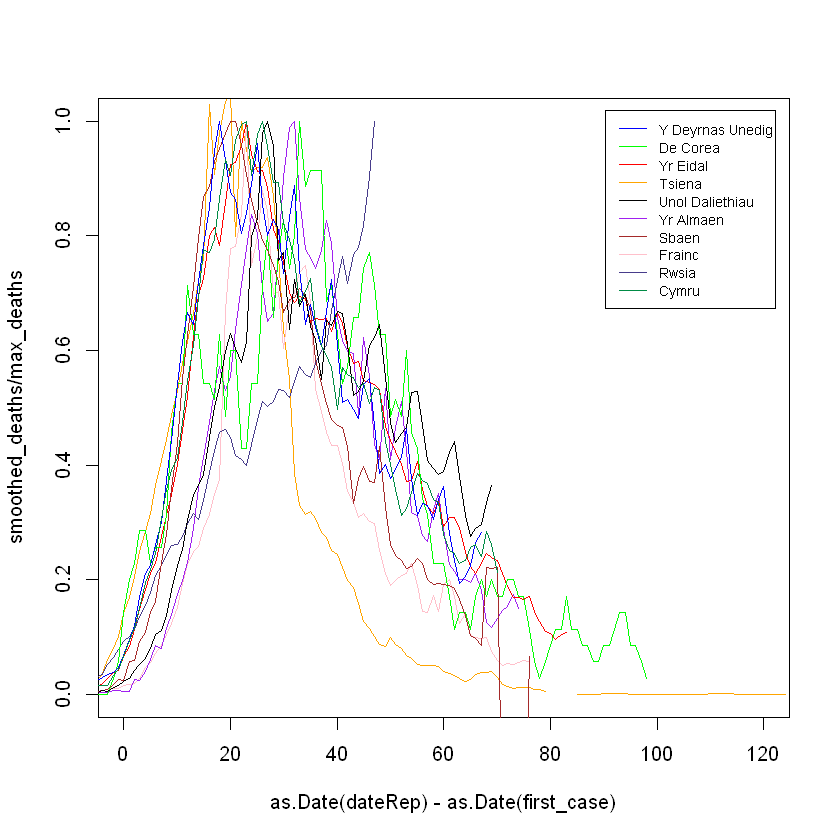

In [9]:
selected_countries <- c('United_Kingdom', 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany', 'Spain', 'France', 'Russia', 'Wales')
legend_countries <- c('Y Deyrnas Unedig', 'De Corea', 'Yr Eidal', 'Tsiena', 'Unol Daliethiau', 'Yr Almaen', 'Sbaen', 'Frainc', 'Rwsia', 'Cymru')
#selected_countries <- c('United_Kingdom', 'South_Korea', 'Italy', 'China', 'United_States_of_America', #'Germany', 'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c('blue', 'green', 'red', 'orange', 'black', 'purple', 'brown', 'pink', 'slateblue4', 'springgreen4', 'goldenrod4', 'midnightblue', 'scarlet')
period <- 120
# Cases (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 36000)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

# Deaths (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 3200)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=legend_countries, col=selected_colors, lty=1, cex=0.7)

[1] 5960.2
Germany ,  18337 ,  5960.2 ,  1 
United_Kingdom ,  18344 ,  5807.4 ,  2 
Wales ,  18340 ,  370.8 ,  3 
Germany ,  18337 ,  265 ,  1 
United_Kingdom ,  18344 ,  1033.2 ,  2 
Wales ,  18340 ,  35.8 ,  3 


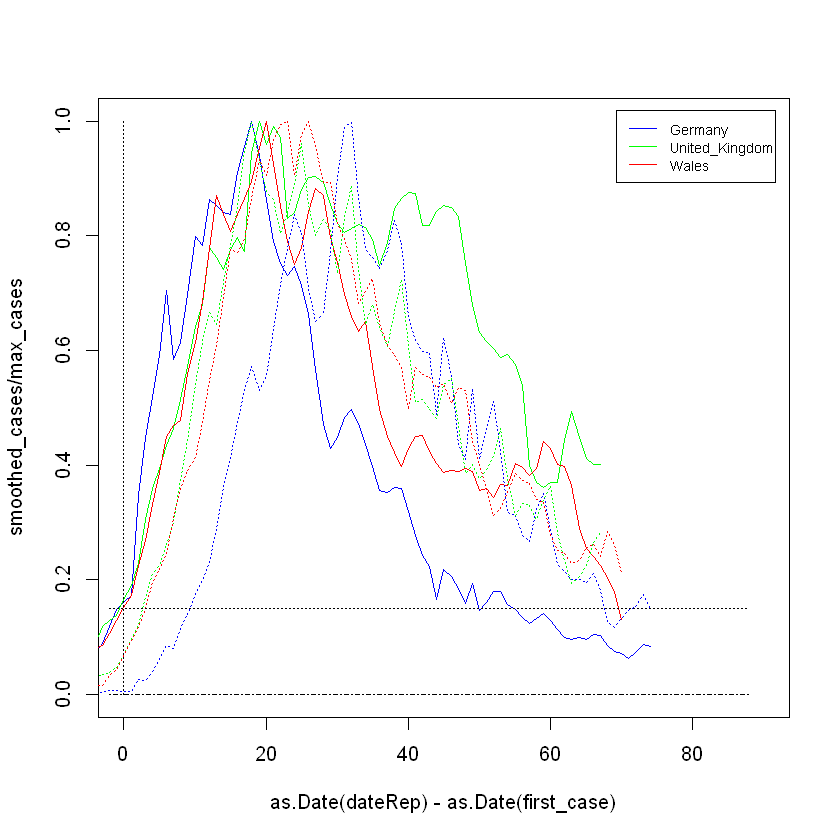

In [10]:
selected_countries <- c('Germany', 'United_Kingdom', 'Wales') #, 'France', 'Italy', 'Greece', 'South_Korea') #'United_Kingdom') #, 'Germany', 'Italy', 'South_Korea', 'Russia', 'Brazil', 'Greece') #, 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany', 'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c('blue', 'green', 'red', 'orange', 'purple', 'black', 'midnightblue', 'pink', 'slateblue4', 'springgreen4', 'goldenrod4', 'pink')
period <- 90
# Get y-scale
i <- 1
y_max <- 0
for (country in selected_countries) {
    max_country_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    if (max_country_cases > y_max) {
        y_max <- max_country_cases
    }
}
print(y_max)
y_max <- 1
# Cases (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}

#i <- 1
#for (country in countries$countriesAndTerritories) {
#    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
#    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
#    if (country %in% selected_countries) {
#        colour <- match(country, selected_countries)
#        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
#        if (i == 1) {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', #col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
#        } else {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', #col=selected_colors[colour]))
#        }
#        i <- i + 1
#    }
#}
# Deaths (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', lty=3, col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', lty=3, col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=selected_countries, col=selected_colors, lty=1, cex=0.7)

#i <- 1
#for (country in countries$countriesAndTerritories) {
#    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
#    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
#    if (country %in% selected_countries) {
#        colour <- match(country, selected_countries)
#        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
#        if (i == 1) {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', #col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
#        } else {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', #col=selected_colors[colour]))
#        }
#        i <- i + 1
#    }
#}
lines(c(0,0), c(0,1), col='black', lty=3)
lines(c(-2,88), c(0.15,0.15), col='black', lty=3)
lines(c(-2,88), c(0,0), col='black', lty=4)

[1] 32785
Brazil ,  18377 ,  24708.4 ,  6 
Germany ,  18337 ,  5960.2 ,  1 
Russia ,  18364 ,  11083 ,  5 
South_Korea ,  18313 ,  661.2 ,  2 
United_Kingdom ,  18344 ,  5807.4 ,  3 
United_States_of_America ,  18342 ,  32785 ,  4 
Brazil ,  18377 ,  1072.2 ,  6 
Germany ,  18337 ,  265 ,  1 
Russia ,  18364 ,  184.4 ,  5 
South_Korea ,  18313 ,  7 ,  2 
United_Kingdom ,  18344 ,  1033.2 ,  3 
United_States_of_America ,  18342 ,  3052.2 ,  4 


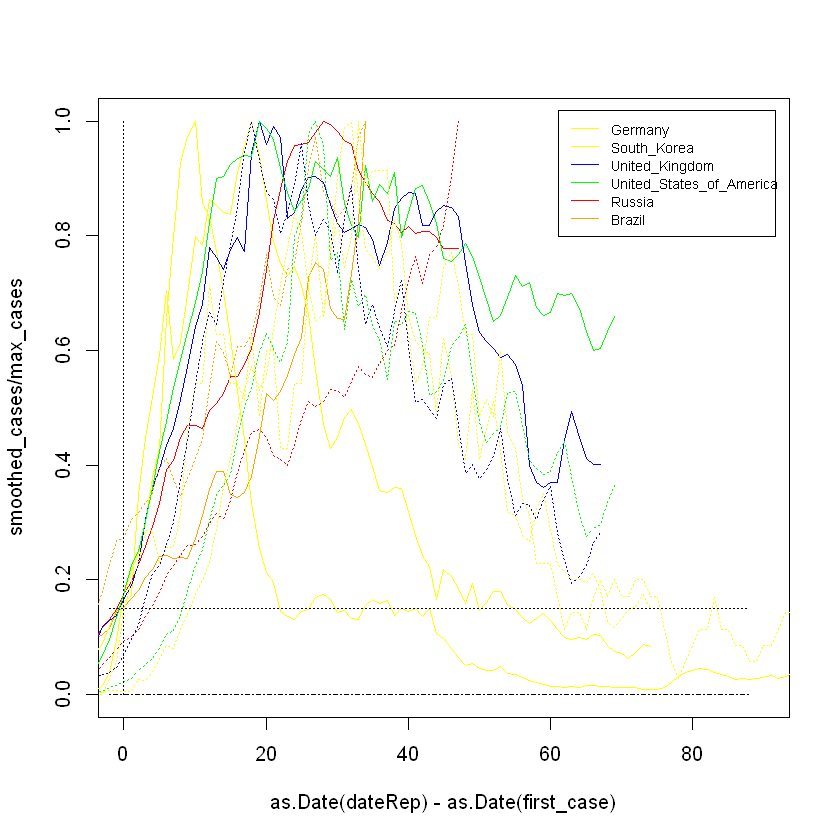

In [11]:
selected_countries <- c('Germany', 'South_Korea', 'United_Kingdom', 'United_States_of_America', 'Russia', 'Brazil') #'United_Kingdom') #, 'Germany', 'Italy', 'South_Korea', 'Russia', 'Brazil', 'Greece') #, 'South_Korea', 'Italy', 'China', 'United_States_of_America', 'Germany', 'Spain', 'France', 'Russia', 'Japan', 'Vietnam', 'Brazil')
selected_colors <- c('yellow', 'yellow', 'blue', 'green', 'red', 'orange', 'purple', 'black', 'midnightblue', 'pink', 'slateblue4', 'springgreen4', 'goldenrod4', 'pink')
period <- 90
# Get y-scale
i <- 1
y_max <- 0
for (country in selected_countries) {
    max_country_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    if (max_country_cases > y_max) {
        y_max <- max_country_cases
    }
}
print(y_max)
y_max <- 1
# Cases (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', col=selected_colors[colour]))
        }
        i <- i + 1
    }
}

#i <- 1
#for (country in countries$countriesAndTerritories) {
#    max_cases <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_cases))[[1]]
#    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
#    if (country %in% selected_countries) {
#        colour <- match(country, selected_countries)
#        cat(country, ', ', first_case, ', ', max_cases, ', ', as.integer(colour), '\n')
#        if (i == 1) {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', #col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
#        } else {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_cases/max_cases, type='l', #col=selected_colors[colour]))
#        }
#        i <- i + 1
#    }
#}
# Deaths (absolute first, then scaled wrt maximum).
i <- 1
for (country in countries$countriesAndTerritories) {
    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
    if (country %in% selected_countries) {
        colour <- match(country, selected_countries)
        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
        if (i == 1) {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', lty=3, col=selected_colors[colour], xlim=c(0, period), ylim=c(0, y_max)))
        } else {
        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', lty=3, col=selected_colors[colour]))
        }
        i <- i + 1
    }
}
legend('topright', inset=0.02, legend=selected_countries, col=selected_colors, lty=1, cex=0.7)

#i <- 1
#for (country in countries$countriesAndTerritories) {
#    max_deaths <- (countries %>% filter(countriesAndTerritories==country) %>% select(max_smoothed_deaths))[[1]]
#    first_case <- (countries %>% filter(countriesAndTerritories==country) %>% select(firstCase))[[1]]
#    if (country %in% selected_countries) {
#        colour <- match(country, selected_countries)
#        cat(country, ', ', first_case, ', ', max_deaths, ', ', as.integer(colour), '\n')
#        if (i == 1) {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), plot(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', #col=selected_colors[colour], xlim=c(0, period), ylim=c(0, 1)))
#        } else {
#        with(cases_deaths %>% filter(countriesAndTerritories==country), lines(as.Date(dateRep) - as.Date(first_case), smoothed_deaths/max_deaths, type='l', #col=selected_colors[colour]))
#        }
#        i <- i + 1
#    }
#}
lines(c(0,0), c(0,1), col='black', lty=3)
lines(c(-2,88), c(0.15,0.15), col='black', lty=3)
lines(c(-2,88), c(0,0), col='black', lty=4)